In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar-10/trainLabels.csv
/kaggle/input/cifar-10/sampleSubmission.csv
/kaggle/input/cifar-10/test.7z
/kaggle/input/cifar-10/train.7z


In [2]:
import torch
import pandas as pd
import numpy as np
import random

random.seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
import torchvision.datasets

CIFAR10_train=torchvision.datasets.CIFAR10(root='./', train=True, download=True)
CIFAR10_test=torchvision.datasets.CIFAR10(root='./', train=False, download=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 49204476.70it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [4]:
X_train = CIFAR10_train.data
y_train = CIFAR10_train.targets
X_test = CIFAR10_test.data
y_test = CIFAR10_test.targets

In [5]:
X_train = np.moveaxis(X_train, 3, 1)
X_test = np.moveaxis(X_test, 3, 1)

In [6]:
X_train.shape

(50000, 3, 32, 32)

In [7]:
def normalize_images(x):
    x_norm = x.astype(np.float32)
    return x_norm/255

In [8]:
X_train = normalize_images(X_train)
X_test = normalize_images(X_test)

In [9]:
X_train = torch.from_numpy(X_train)
y_train = torch.as_tensor(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.as_tensor(y_test)

In [10]:
len(y_train), len(y_test)

(50000, 10000)

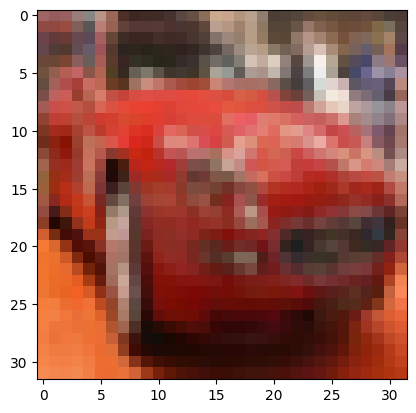

tensor(6)


In [11]:
import matplotlib.pyplot as plt
plt.imshow(np.transpose(X_train[5,:,:,:], (1,2,0)))
plt.show()
print(y_train[0])

# LeNet

In [12]:
class LeNet5(torch.nn.Module):
  def __init__(self):
    super (LeNet5, self).__init__()

    self.conv1 = torch.nn.Conv2d(
        in_channels = 3, out_channels = 6, kernel_size = 5, padding = 2)
    self.act1 = torch.nn.Tanh()
    self.pool1 = torch.nn.AvgPool2d(kernel_size = 2, stride = 2)
    self.conv2 = torch.nn.Conv2d(
        in_channels = 6, out_channels = 16, kernel_size = 5, padding = 0)
    self.act2 = torch.nn.Tanh()
    self.pool2 = torch.nn.AvgPool2d(kernel_size = 2, stride = 2)

    self.fc1 = torch.nn.Linear(6*6*16,120)
    self.act3 = torch.nn.Tanh()

    self.fc2 = torch.nn.Linear(120,84)
    self.act4 = torch.nn.Tanh()

    self.fc3 = torch.nn.Linear(84,10)

  def forward(self,x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.act2(x)
    x = self.pool2(x)

    x = x.view(x.size(0), x.size(1)* x.size(2) * x.size(3))

    x = self.fc1(x)
    x = self.act3(x)
    x = self.fc2(x)
    x = self.act4(x)
    x = self.fc3(x)

    return x

net_LeNet = LeNet5()

In [13]:
def trainLeNet(net):
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  net = net.to(device)

  loss = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

  batch_size = 30

  test_acc = []
  test_loss = []

  dev_X_test = X_test.to(device)
  dev_y_test = y_test.to(device)

  for e in range(20):
    order = np.random.permutation(len(X_train))
    net.train()
    for i in range(0, len(X_train), batch_size):
      optimizer.zero_grad()

      batch_ind = order[i:i+batch_size]

      X_batch = X_train[batch_ind].to(device)
      y_batch = y_train[batch_ind].to(device)
      preds = net.forward(X_batch)
      loss_val = loss(preds, y_batch)
      loss_val.backward()

      optimizer.step()

    net.eval()
    with torch.no_grad():
      test_preds = net.forward(dev_X_test)
      test_loss.append(loss(test_preds, dev_y_test).data.cpu())

      acc = (test_preds.argmax(dim = 1) == dev_y_test).float().mean().data.cpu()
      test_acc.append(acc)

    print(acc, "   ", test_loss[-1])
  return test_loss

In [14]:
test_loss = trainLeNet(net_LeNet)

tensor(0.4410)     tensor(1.5739)
tensor(0.4978)     tensor(1.4386)
tensor(0.5131)     tensor(1.3678)
tensor(0.5337)     tensor(1.3329)
tensor(0.5311)     tensor(1.3281)
tensor(0.5285)     tensor(1.3350)
tensor(0.5389)     tensor(1.3386)
tensor(0.5402)     tensor(1.3142)
tensor(0.5446)     tensor(1.3123)
tensor(0.5469)     tensor(1.3085)
tensor(0.5531)     tensor(1.3097)
tensor(0.5495)     tensor(1.3161)
tensor(0.5540)     tensor(1.3234)
tensor(0.5470)     tensor(1.3497)
tensor(0.5336)     tensor(1.4052)
tensor(0.5512)     tensor(1.3678)
tensor(0.5434)     tensor(1.3994)
tensor(0.5440)     tensor(1.4244)
tensor(0.5441)     tensor(1.4394)
tensor(0.5393)     tensor(1.4612)


# ReLU

In [15]:
class LeNet5ReLU(torch.nn.Module):
  def __init__(self):
    super (LeNet5ReLU, self).__init__()

    self.conv1 = torch.nn.Conv2d(
        in_channels = 3, out_channels=6, kernel_size = 5, padding = 2)
    self.act1 = torch.nn.ReLU()
    self.pool1 = torch.nn.AvgPool2d(kernel_size= 2, stride = 2)
    self.conv2 = torch.nn.Conv2d(
        in_channels = 6, out_channels=16, kernel_size = 5, padding = 0)
    self.act2 = torch.nn.ReLU()
    self.pool2 = torch.nn.AvgPool2d(kernel_size= 2, stride = 2)

    self.fc1 = torch.nn.Linear(6*6*16,120)
    self.act3 = torch.nn.ReLU()

    self.fc2 = torch.nn.Linear(120,84)
    self.act4 = torch.nn.ReLU()

    self.fc3 = torch.nn.Linear(84,10)

  def forward(self,x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.act2(x)
    x = self.pool2(x)

    x = x.view(x.size(0), x.size(1)* x.size(2) * x.size(3))

    x = self.fc1(x)
    x = self.act3(x)
    x = self.fc2(x)
    x = self.act4(x)
    x = self.fc3(x)

    return x

net_ReLU = LeNet5ReLU()

In [16]:
test_loss_ReLU = trainLeNet(net_ReLU)

tensor(0.4360)     tensor(1.5389)
tensor(0.4973)     tensor(1.3813)
tensor(0.5147)     tensor(1.3398)
tensor(0.5364)     tensor(1.3042)
tensor(0.5462)     tensor(1.2622)
tensor(0.5447)     tensor(1.2626)
tensor(0.5661)     tensor(1.2362)
tensor(0.5822)     tensor(1.1851)
tensor(0.5884)     tensor(1.1590)
tensor(0.5917)     tensor(1.1682)
tensor(0.5979)     tensor(1.1372)
tensor(0.5879)     tensor(1.1643)
tensor(0.5782)     tensor(1.2081)
tensor(0.5923)     tensor(1.1720)
tensor(0.5998)     tensor(1.1416)
tensor(0.5899)     tensor(1.1908)
tensor(0.6070)     tensor(1.1397)
tensor(0.5877)     tensor(1.1805)
tensor(0.5980)     tensor(1.1612)
tensor(0.6081)     tensor(1.1560)


# MaxPooling

In [17]:
class LeNet5MaxPool(torch.nn.Module):
  def __init__(self):
    super (LeNet5MaxPool, self).__init__()

    self.conv1 = torch.nn.Conv2d(
        in_channels = 3, out_channels=6, kernel_size = 5, padding = 2)
    self.act1 = torch.nn.ReLU()
    self.pool1 = torch.nn.MaxPool2d(kernel_size= 2, stride = 2)
    self.conv2 = torch.nn.Conv2d(
        in_channels = 6, out_channels=16, kernel_size = 5, padding = 0)
    self.act2 = torch.nn.ReLU()
    self.pool2 = torch.nn.MaxPool2d(kernel_size= 2, stride = 2)

    self.fc1 = torch.nn.Linear(6*6*16,120)
    self.act3 = torch.nn.ReLU()

    self.fc2 = torch.nn.Linear(120,84)
    self.act4 = torch.nn.ReLU()

    self.fc3 = torch.nn.Linear(84,10)

  def forward(self,x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.act2(x)
    x = self.pool2(x)

    x = x.view(x.size(0), x.size(1)* x.size(2) * x.size(3))

    x = self.fc1(x)
    x = self.act3(x)
    x = self.fc2(x)
    x = self.act4(x)
    x = self.fc3(x)

    return x

net_MaxPool = LeNet5MaxPool()

In [18]:
test_loss_MaxPool = trainLeNet(net_MaxPool)

tensor(0.4739)     tensor(1.4393)
tensor(0.5103)     tensor(1.3408)
tensor(0.5374)     tensor(1.2895)
tensor(0.5741)     tensor(1.1854)
tensor(0.5774)     tensor(1.1834)
tensor(0.5906)     tensor(1.1510)
tensor(0.6006)     tensor(1.1171)
tensor(0.5964)     tensor(1.1475)
tensor(0.6145)     tensor(1.0892)
tensor(0.6036)     tensor(1.1327)
tensor(0.6115)     tensor(1.1256)
tensor(0.6185)     tensor(1.0998)
tensor(0.6223)     tensor(1.1000)
tensor(0.6040)     tensor(1.1637)
tensor(0.6124)     tensor(1.1279)
tensor(0.6141)     tensor(1.1526)
tensor(0.6141)     tensor(1.1865)
tensor(0.6156)     tensor(1.1718)
tensor(0.6138)     tensor(1.1858)
tensor(0.6174)     tensor(1.1598)


# Double

In [19]:
class LeNet5Double(torch.nn.Module):
  def __init__(self):
    super (LeNet5Double, self).__init__()

    self.conv1_1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=3, padding=0)
    self.conv1_2 = torch.nn.Conv2d(
                in_channels=6, out_channels=6, kernel_size=3, padding=0)

    self.conv2_1 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=3, padding=0)
    self.conv2_2 = torch.nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=0)

    self.act1 = torch.nn.ReLU()
    self.pool1 = torch.nn.MaxPool2d(kernel_size= 2, stride = 2)

    self.act2 = torch.nn.ReLU()
    self.pool2 = torch.nn.MaxPool2d(kernel_size= 2, stride = 2)

    self.fc1 = torch.nn.Linear(5*5*16,120)
    self.act3 = torch.nn.ReLU()

    self.fc2 = torch.nn.Linear(120,84)
    self.act4 = torch.nn.ReLU()

    self.fc3 = torch.nn.Linear(84,10)

  def forward(self,x):
    x = self.conv1_2(self.conv1_1(x))
    x = self.act1(x)
    x = self.pool1(x)

    x = self.conv2_2(self.conv2_1(x))
    x = self.act2(x)
    x = self.pool2(x)

    x = x.view(x.size(0), x.size(1)* x.size(2) * x.size(3))

    x = self.fc1(x)
    x = self.act3(x)
    x = self.fc2(x)
    x = self.act4(x)
    x = self.fc3(x)

    return x

net_Double = LeNet5Double()

In [20]:
test_loss_Double = trainLeNet(net_Double)

tensor(0.4528)     tensor(1.4946)
tensor(0.5102)     tensor(1.3624)
tensor(0.5381)     tensor(1.2961)
tensor(0.5830)     tensor(1.1853)
tensor(0.5919)     tensor(1.1525)
tensor(0.6021)     tensor(1.1311)
tensor(0.6132)     tensor(1.1111)
tensor(0.5812)     tensor(1.1872)
tensor(0.6075)     tensor(1.1269)
tensor(0.6383)     tensor(1.0484)
tensor(0.6371)     tensor(1.0446)
tensor(0.6475)     tensor(1.0297)
tensor(0.6472)     tensor(1.0289)
tensor(0.6505)     tensor(1.0310)
tensor(0.6546)     tensor(1.0424)
tensor(0.6467)     tensor(1.0512)
tensor(0.6558)     tensor(1.0341)
tensor(0.6601)     tensor(1.0459)
tensor(0.6616)     tensor(1.0439)
tensor(0.6525)     tensor(1.0638)


# BatchNorm

In [21]:
class LeNet5BatchNorm(torch.nn.Module):
  def __init__(self):
    super (LeNet5BatchNorm, self).__init__()

    self.conv1_1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=3, padding=0)
    self.bn1_1 = torch.nn.BatchNorm2d(6)

    self.conv1_2 = torch.nn.Conv2d(
                in_channels=6, out_channels=6, kernel_size=3, padding=0)
    self.bn1_2 = torch.nn.BatchNorm2d(6)

    self.conv2_1 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=3, padding=0)
    self.bn2_1 = torch.nn.BatchNorm2d(16)

    self.conv2_2 = torch.nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=0)
    self.bn2_2 = torch.nn.BatchNorm2d(16)

    self.act1 = torch.nn.ReLU()
    self.pool1 = torch.nn.MaxPool2d(kernel_size= 2, stride = 2)

    self.act2 = torch.nn.ReLU()
    self.pool2 = torch.nn.MaxPool2d(kernel_size= 2, stride = 2)

    self.fc1 = torch.nn.Linear(5*5*16,120)
    self.bn3 = torch.nn.BatchNorm1d(120)
    self.act3 = torch.nn.ReLU()

    self.fc2 = torch.nn.Linear(120,84)
    self.bn4 = torch.nn.BatchNorm1d(84)
    self.act4 = torch.nn.ReLU()

    self.fc3 = torch.nn.Linear(84,10)

  def forward(self,x):
    x = self.conv1_2(self.bn1_1(self.conv1_1(x)))
    x = self.bn1_2(x)
    x = self.act1(x)
    x = self.pool1(x)

    x = self.conv2_2(self.bn2_1(self.conv2_1(x)))
    x = self.bn2_2(x)
    x = self.act2(x)
    x = self.pool2(x)

    x = x.view(x.size(0), x.size(1)* x.size(2) * x.size(3))

    x = self.fc1(x)
    x = self.bn3(x)
    x = self.act3(x)

    x = self.fc2(x)
    x = self.bn4(x)
    x = self.act4(x)

    x = self.fc3(x)

    return x

net_BatchNorm = LeNet5BatchNorm()

In [22]:
test_loss_BatchNorm = trainLeNet(net_BatchNorm)

tensor(0.5931)     tensor(1.1561)
tensor(0.6387)     tensor(1.0217)
tensor(0.6637)     tensor(0.9732)
tensor(0.6510)     tensor(1.0163)
tensor(0.6553)     tensor(0.9887)
tensor(0.6848)     tensor(0.9136)
tensor(0.6944)     tensor(0.8878)
tensor(0.6835)     tensor(0.9296)
tensor(0.6942)     tensor(0.8855)
tensor(0.6909)     tensor(0.9083)
tensor(0.6901)     tensor(0.9040)
tensor(0.6926)     tensor(0.9078)
tensor(0.6923)     tensor(0.9108)
tensor(0.6924)     tensor(0.9161)
tensor(0.6947)     tensor(0.9194)
tensor(0.6923)     tensor(0.9496)
tensor(0.6914)     tensor(0.9722)
tensor(0.6880)     tensor(0.9579)
tensor(0.6872)     tensor(0.9725)
tensor(0.6865)     tensor(0.9998)


# Conclusion

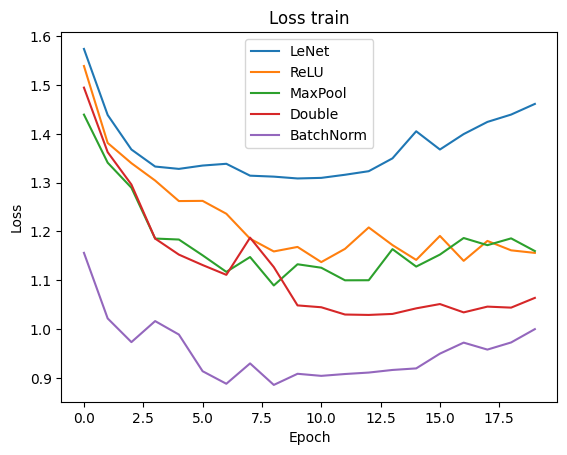

In [23]:
plt.plot(test_loss, label='LeNet')
plt.plot(test_loss_ReLU, label='ReLU')
plt.plot(test_loss_MaxPool, label='MaxPool')
plt.plot(test_loss_Double, label='Double')
plt.plot(test_loss_BatchNorm, label='BatchNorm')

plt.title('Loss train')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [24]:
!pip install  py7zr

import py7zr
import os

folder_path = '/kaggle/working/test_comp'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Directory {folder_path} created successfully.")
else:
    print(f"Directory {folder_path} already exists.")

with py7zr.SevenZipFile('/kaggle/input/cifar-10/test.7z', mode='r') as z:
    z.extractall(folder_path)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 24.7 MB/s eta 0:00:00
Directory /kaggle/working/test_comp created successfully.


In [25]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

test_filenames = [os.path.join('/kaggle/working/test_comp/test', f) for f in os.listdir('/kaggle/working/test_comp/test')]
test_filenames.sort(key=lambda x: int(x.split('/')[-1].split('.')[0]))

class CIFAR10(Dataset):
    def __init__(self, filenames, transforms):
        self.filenames = filenames
        self.transforms = transforms
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        img = np.asarray(Image.open(self.filenames[idx]))
        img = np.moveaxis(img, 2, 0)
        transformed_img = self.transforms(img)
        return transformed_img

test_dataset = CIFAR10(test_filenames, normalize_images)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

result = []
with torch.no_grad():
    net_BatchNorm.eval()
    for batch_in in test_loader:
        batch_in = batch_in.to(device)
        
        y_pred = net_BatchNorm(batch_in)
        preds = torch.argmax(y_pred, 1)
        preds = preds.cpu().numpy()
        result.extend([classes[i] for i in preds])
        
sample = pd.read_csv('/kaggle/input/cifar-10/sampleSubmission.csv')
sample['label'] = result
sample.to_csv('./submission.csv', index=False)